In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import os

In [3]:
os.chdir( "/content/gdrive/MyDrive/flair" ) 

In [ ]:
pip install flair

In [6]:
from flair.data import Corpus
from flair.data_fetcher import NLPTaskDataFetcher

downsample = 1.0 # 1.0 is full data, try a much smaller number like 0.01 to test run the code
data_folder = os.getcwd()
columns = {0: 'text', 1: 'ner'}

# 1. get the corpus
corpus: Corpus = NLPTaskDataFetcher.load_column_corpus(data_folder, columns,
                                                             train_file='training_data.csv',
                                                             test_file='test_data.csv',
                                                           dev_file=None).downsample(downsample)
print(corpus)

2021-05-22 11:23:02,442 Reading data from /content/gdrive/My Drive/flair
2021-05-22 11:23:02,443 Train: /content/gdrive/My Drive/flair/training_data.csv
2021-05-22 11:23:02,444 Dev: None
2021-05-22 11:23:02,445 Test: /content/gdrive/My Drive/flair/test_data.csv


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) load_column_corpus. (Use 'flair.datasets' instead.) -- Deprecated since version 0.4.1.
  if sys.path[0] == '':


Corpus: 6290 train + 699 dev + 3322 test sentences


Now, we have loaded __flair__ and our data.<br>
Next, we train models for __NER__.<br>
Inform yourselves on [Embeddings](https://github.com/flairNLP/flair/blob/master/resources/docs/TUTORIAL_3_WORD_EMBEDDING.md) in Flair.<br>
__Question 1__: What happens when we stack embeddings?<br>

When we stack embeddings, we can create way more powerful models. For example we could stack our model with a BERT or ELMO Word embedding. We could also combine the character level, the flair embedding and BERT, but this takes too to train.

<br>

How does this influence computational running time and accuracy?<br>

The accuracy will most likely increase when we stack the embeddings, because we can capture more complexity, but the computational running time will increase dramatically. 

<br>

What does the __hidden_size__ of the __SequenceTagger__ reference?<br>
What happens when you increase/decrease the __hidden_size__?

The hidden size is basically the amount of `neurons` of the Embedding Layer. It is like the hidden_size of a hidden layer in a fully connected network. We therefore need a sufficient big enough hidden_size, but we can't know what the best value for hidden_size is. 256 or 512 are profound values that are often used. 

When we increase it, the computation time will rise, when we decrease it, the time will shrink due to fewer matrix multiplications.

In [8]:
# 4. initialize embeddings. Experiment with different embedding types to see what gets the best results
from flair.embeddings import TokenEmbeddings, WordEmbeddings, StackedEmbeddings,FlairEmbeddings, CharacterEmbeddings

embedding_types = [
    WordEmbeddings('glove'),
    # comment in this line to use character embeddings
    CharacterEmbeddings(),

    # comment in these lines to use flair embeddings (needs a LONG time to train :-)
    #FlairEmbeddings('news-forward'),
    #FlairEmbeddings('news-backward'),
]

embeddings: StackedEmbeddings = StackedEmbeddings(embeddings=embedding_types)

# 5. initialize sequence tagger
from flair.models import SequenceTagger

tag_type = "ner"
tag_dictionary = corpus.make_tag_dictionary(tag_type=tag_type)

tagger: SequenceTagger = SequenceTagger(hidden_size=256,
                                        embeddings=embeddings,
                                        tag_dictionary=tag_dictionary,
                                        tag_type=tag_type,
                                        use_crf=True)

2021-05-22 11:23:54,403 https://flair.informatik.hu-berlin.de/resources/characters/common_characters not found in cache, downloading to /tmp/tmp5xi3gk29


100%|██████████| 2887/2887 [00:00<00:00, 822395.79B/s]

2021-05-22 11:23:54,724 copying /tmp/tmp5xi3gk29 to cache at /root/.flair/datasets/common_characters
2021-05-22 11:23:54,729 removing temp file /tmp/tmp5xi3gk29


Start Training

In [9]:
# 6. initialize trainer
from flair.trainers import ModelTrainer

trainer: ModelTrainer = ModelTrainer(tagger, corpus)

model_name = 'flair_glove'

trainer.train(model_name,
              learning_rate=0.1,
              mini_batch_size=10,
              #anneal_with_restarts=True,
              max_epochs=5)

2021-05-22 11:24:12,079 ----------------------------------------------------------------------------------------------------
2021-05-22 11:24:12,081 Model: "SequenceTagger(
  (embeddings): StackedEmbeddings(
    (list_embedding_0): WordEmbeddings('glove')
    (list_embedding_1): CharacterEmbeddings(
      (char_embedding): Embedding(275, 25)
      (char_rnn): LSTM(25, 25, bidirectional=True)
    )
  )
  (word_dropout): WordDropout(p=0.05)
  (locked_dropout): LockedDropout(p=0.5)
  (embedding2nn): Linear(in_features=150, out_features=150, bias=True)
  (rnn): LSTM(150, 256, batch_first=True, bidirectional=True)
  (linear): Linear(in_features=512, out_features=16, bias=True)
  (beta): 1.0
  (weights): None
  (weight_tensor) None
)"
2021-05-22 11:24:12,083 ----------------------------------------------------------------------------------------------------
2021-05-22 11:24:12,086 Corpus: "Corpus: 6290 train + 699 dev + 3322 test sentences"
2021-05-22 11:24:12,087 ---------------------------

{'dev_loss_history': [2.4661312103271484,
  2.0670511722564697,
  2.014693021774292,
  1.495338797569275,
  1.7524528503417969],
 'dev_score_history': [0.17955112219451372,
  0.30979498861047833,
  0.39556377079482435,
  0.4349514563106796,
  0.4376130198915009],
 'test_score': 0.46540362438220756,
 'train_loss_history': [4.495144929562137,
  2.9645907472410435,
  2.5019682600460533,
  2.3273426864935836,
  2.270780367400669]}

2021-05-22 11:55:16,464 ----------------------------------------------------------------------------------------------------
2021-05-22 11:55:16,466 WARNING: No LOSS found for test split in this data.
2021-05-22 11:55:16,467 Are you sure you want to plot LOSS and not another value?
2021-05-22 11:55:16,468 ----------------------------------------------------------------------------------------------------
2021-05-22 11:55:16,495 ----------------------------------------------------------------------------------------------------
2021-05-22 11:55:16,496 WARNING: No F1 found for test split in this data.
2021-05-22 11:55:16,497 Are you sure you want to plot F1 and not another value?
2021-05-22 11:55:16,498 ----------------------------------------------------------------------------------------------------
Loss and F1 plots are saved in /content/gdrive/MyDrive/flair/flair_glove/training.png


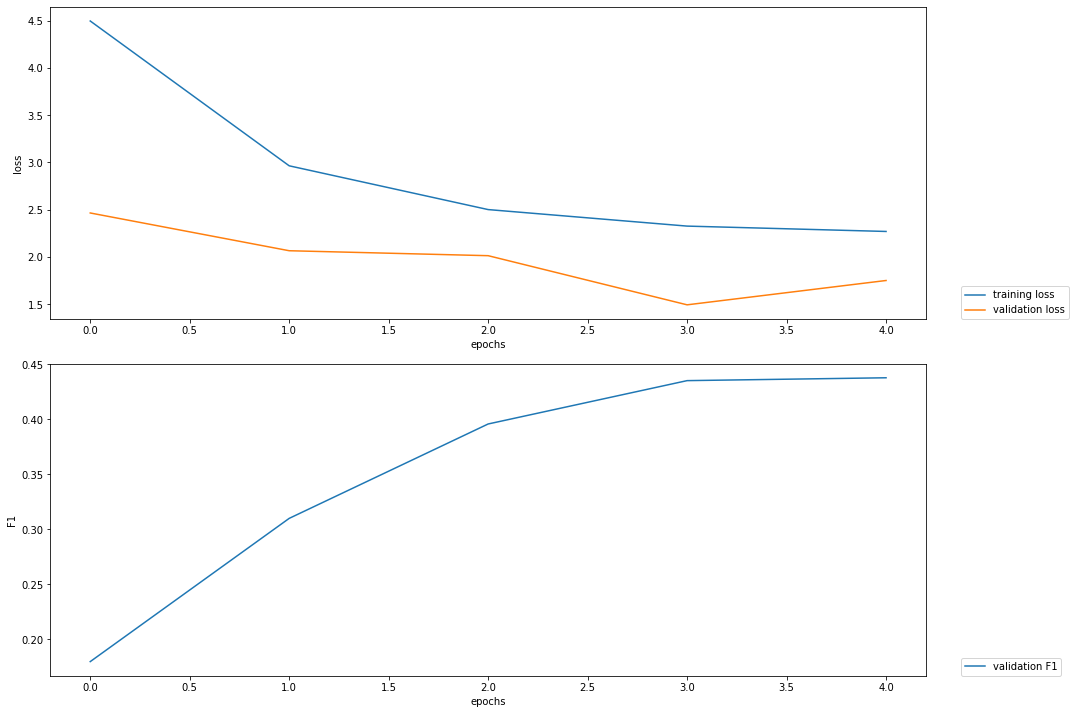

In [11]:
from flair.visual.training_curves import Plotter
plotter = Plotter()
plotter.plot_training_curves( os.getcwd() + '/flair_glove/loss.tsv')

__Question 2__: Suggest, how could you improve the F1-value?<br>
Are 5 epochs enough for training?<br>

We can see that the training loss is still shrinking, but the validation loss is still not really rising that much. Therefore we probably didn't find the sweat-spot yet. I would train until epoch 10 and check again if we find a lower loss.

How could you speed up computation?

We can speed it up by:
- reduce hidden_size
- fewer training data
- no character level embedding